In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
theano.config.floatX ='float32'
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to_value(u.TeV), fit_range.to_value(u.TeV))
    return [a[idx[0]:idx[1]] for a in arr]

In [4]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=None):
    
    amplitude *= 1e-11
    
    predicted_signal_per_observation = []
    for observation in observations:
        obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)


        aeff_bins = observation.aeff.energy
        e_reco_bins = observation.edisp.e_reco
        e_true_bins = observation.edisp.e_true

        lower =  e_true_bins.lo.to_value(u.TeV)
        upper = e_true_bins.hi.to_value(u.TeV)

        energy = T.dscalar('energy')
        amplitude_ = T.dscalar('amplitude_')
        alpha_ = T.dscalar('alpha_')
        beta_ = T.dscalar('beta_')

        func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))

        counts = []
        for a, b in zip(lower, upper):
            c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
            counts.append(c)

        counts = T.stack(counts)
        aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
        aeff = aeff


        counts *= aeff
        counts *= observation.livetime.to_value(u.s)
        edisp = observation.edisp.pdf_matrix
        edisp = edisp

        predicted_signal_per_observation.append(T.dot(counts, edisp))

    predicted_counts = T.sum(predicted_signal_per_observation, axis=0)
    if fit_range is not None:
        idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))
        predicted_counts = predicted_counts[idx[0]:idx[1]]

    return predicted_counts

In [5]:
observations, fit_range = load_spectrum_observations('magic')
# observation = obs_list[1]
obs_alpha = observations[0].alpha[0]
energy_bins = observations[0].on_vector.energy.bins

observations, fit_range # [obs.alpha for obs in observations]

([<gammapy.spectrum.observation.SpectrumObservation object at 0x7f19f9eb9518>, <gammapy.spectrum.observation.SpectrumObservation object at 0x7f19f9d96f98>],
 <Quantity [ 0.08, 30.  ] TeV>)

In [6]:
def get_observed_counts(observations, fit_range=None):
    on_data = []
    off_data = []
    
    for observation in observations:
        on_data.append(observation.on_vector.data.data.value)
        off_data.append(observation.off_vector.data.data.value)
    on_data = np.sum(on_data, axis=0)
    off_data = np.sum(off_data, axis=0)
    if fit_range is not None:
        on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)
    
    return on_data, off_data

In [8]:
on_data, off_data = get_observed_counts(observations, fit_range=fit_range)
exposure_ratio = observations[0].alpha[0]   # 1/9 = 0.11111

model = pm.Model(theano_config={'compute_test_value': 'ignore'})

with model:

    amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=2.5, lower=0, testval=4)
    alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=1, lower=0, testval=2.5)
    beta = pm.TruncatedNormal('beta', mu=0.5, sd=0.5, lower=0, testval=0.5)
    
#     amplitude = pm.HalfFlat('amplitude',testval=4)
#     alpha = pm.HalfFlat('alpha', testval=2.5)
#     beta = pm.HalfFlat('beta', testval=0.5)
    
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=fit_range,)

    mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
#     log_mu_b = pm.Normal('log_mu_b', mu=np.log(off_data + 0.001), sd=4, shape=len(off_data))
#     mu_b = pm.math.exp(log_mu_b)
    
    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

In [9]:
model.test_point

{'amplitude_lowerbound__': array(1.3862944, dtype=float32),
 'alpha_lowerbound__': array(0.91629076, dtype=float32),
 'beta_lowerbound__': array(-0.6931472, dtype=float32),
 'mu_b_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

625it [00:39, 15.75it/s]


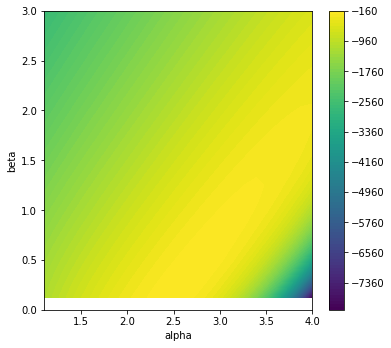

In [10]:
N = 25
betas = np.linspace(0, 3, N)
alphas = np.linspace(1.1, 4.0, N)
f = model.logp
zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
        
    p = f(amplitude_lowerbound__ = np.log(4.0), alpha_lowerbound__ = np.log(al), beta_lowerbound__= np.log(be), mu_b_log__ = np.log(off_data + 0.01))
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=124)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [11]:
map_estimate = pm.find_MAP(model=model, start={'amplitude': 4.0})
map_estimate

logp = -196.55, ||grad|| = 46.73: 100%|██████████| 83/83 [00:24<00:00,  3.37it/s]     


{'amplitude_lowerbound__': array(1.3270814, dtype=float32),
 'alpha_lowerbound__': array(0.95412374, dtype=float32),
 'beta_lowerbound__': array(-0.9562605, dtype=float32),
 'mu_b_log__': array([ 5.0481253e+00,  4.9429307e+00,  4.8853126e+00,  4.1374860e+00,
         3.6635911e+00,  3.6391220e+00,  3.7213988e+00,  3.0474072e+00,
         3.6088526e+00,  3.4059150e+00,  2.4483099e+00,  2.5723820e+00,
         1.8180507e+00,  1.4581044e+00,  7.4837786e-01,  7.6161808e-01,
         7.5380421e-01,  5.6863081e-01,  3.9307934e-01,  5.6859618e-01,
        -5.9506821e-04, -1.4270658e-03, -7.9847863e-03,  1.7704138e-01,
        -1.9655132e-01, -1.9156034e-01,  1.6580591e-02, -2.1839064e-01,
        -2.0573619e-01, -1.8776660e-01, -1.9909728e-01, -1.2511580e-03,
        -1.2067906e-01, -1.7778593e-01, -2.1839064e-01, -2.1839064e-01,
        -2.1839064e-01, -1.3790153e-01, -2.1839064e-01, -1.0898638e-01,
        -2.1839064e-01, -2.1839064e-01, -2.1839064e-01, -2.1839064e-01,
        -2.1839064e-0

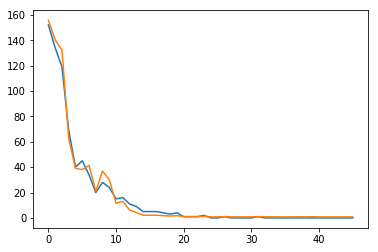

In [13]:
plt.plot(off_data)
plt.plot(map_estimate['mu_b'])

In [14]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(600, chains=6, cores=6, init='auto', target_accept=0.90, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu_b, beta, alpha, amplitude]
Sampling 6 chains: 100%|██████████| 7800/7800 [2:52:23<00:00,  4.09s/draws]  
The acceptance probability does not match the target. It is 0.8858602358652407, but should be close to 0.8. Try to increase the number of tuning steps.


/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19aac956a0>,
      dtype=object)

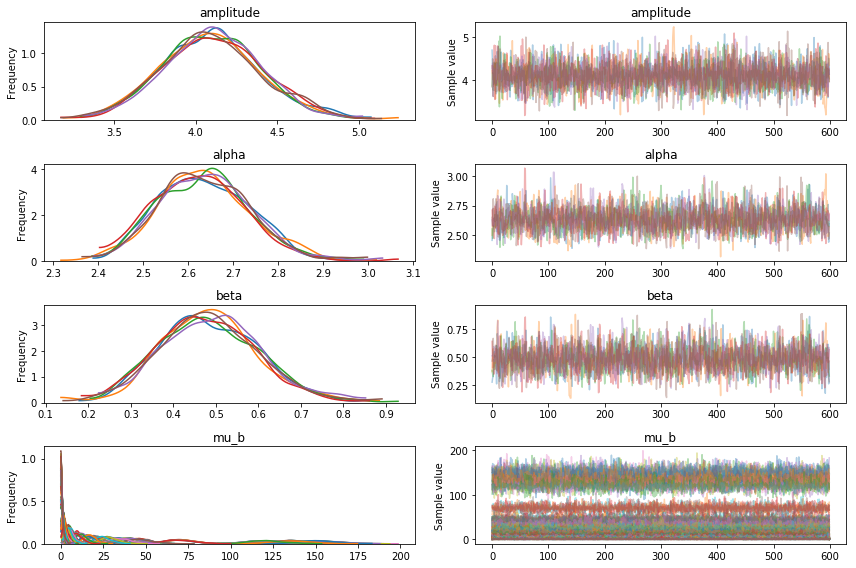

In [15]:
pm.traceplot(trace)

In [16]:
with model:
    samples = pm.sample_ppc(trace)

  0%|          | 0/600 [00:00<?, ?it/s]

ValueError: Cannot sample from HalfFlat distribution

In [ ]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(on_data, color='red')

plt.figure()
plt.plot(samples['background'].T, color='k', alpha=0.1)
plt.plot(off_data, color='red')

None

In [17]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
amplitude,4.100000,0.306,0.004,3.497,4.699,4828.603,1.000
alpha,2.637000,0.102,0.002,2.448,2.836,2539.844,1.001
beta,0.485000,0.116,0.002,0.255,0.703,2915.206,1.001
mu_b__0,151.427994,12.124,0.149,127.829,175.662,6294.884,1.000
mu_b__1,135.561996,11.444,0.146,114.818,159.764,7189.944,1.000
mu_b__2,120.837997,11.086,0.127,99.402,142.669,7454.003,0.999
mu_b__3,70.292000,8.350,0.097,54.718,86.519,7163.970,1.000
mu_b__4,40.515999,5.996,0.066,29.392,52.565,8325.788,0.999
mu_b__5,46.234001,6.843,0.082,33.181,59.780,6886.731,0.999
mu_b__6,34.987999,5.972,0.071,24.085,47.087,8065.286,0.999


In [18]:
trace['amplitude'].mean(), trace['alpha'].mean(), trace['beta'].mean()

(4.0995317, 2.63654, 0.48548934)

In [19]:
np.median(trace['amplitude']), np.median(trace['alpha']), np.median(trace['beta'])

(4.0953255, 2.6334348, 0.48123848)

In [20]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


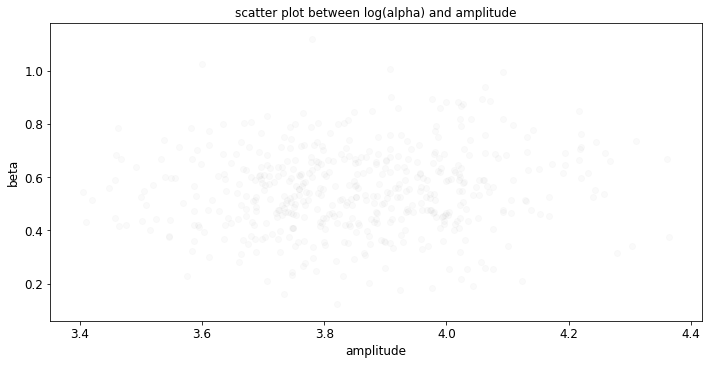

In [98]:
pm.pairplot(trace,
           sub_varnames=['amplitude', 'beta'],
           divergences=True,
           color='k', alpha=0.02, figsize=(10, 5), kwargs_divergence={'color':'C2'})
plt.title('scatter plot between log(alpha) and amplitude');

In [112]:
from collections import defaultdict
divergent_point = defaultdict(list)

chain_warn = trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in model.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in model.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])

ii = 5
amplitude_log_d = divergent_point['amplitude_log__']
# print(divergent_point)
mu_5_d = divergent_point['log_mu_b'][:, ii]
Ndiv_recorded = len(divergent_point['log_mu_b'])
mu_5_d

IndexError: too many indices for array

KeyError: 'mu_b_log___5'

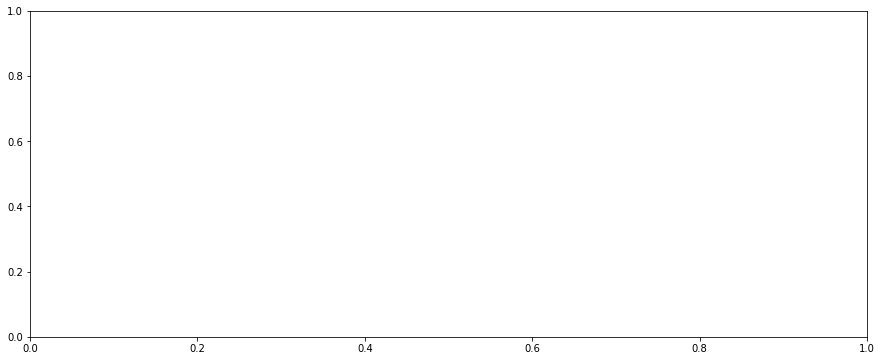

In [104]:
param = 'alpha_log__'
parameter_log_divergence = divergent_point[param]

_, ax = plt.subplots(1, 1, figsize=(15, 6))
pm.pairplot(trace,
               sub_varnames=['mu_b_log___5', param],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

mu_trace = trace['mu_b_log__']
mu_0 = mu_trace[:, 5]

plt.plot([mu_0[divergent == 1][:Ndiv_recorded], mu_0_d], 
         [trace[param][divergent == 1][:Ndiv_recorded], parameter_log_divergence], 'k-', alpha=.25)

plt.scatter(mu_0_d, parameter_log_divergence,
              color='C3', alpha=.9, label='Location of Energy error (start location of leapfrog)')
# ax.scatter(divsp.T, 'C3', lw=.5)
# plt.title('scatter plot between log(tau) and theta[0]')
plt.legend()


In [113]:
tracedf = pm.trace_to_dataframe(trace)
plotorder = ['amplitude', 'alpha', 'beta'] + [f'mu_b__{i}' for i in range(len(off_data))]
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 1, figsize=(12, 5))
# ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
# ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.01)
ax.plot(tracedf.values[divergent == 1].T, color='C2', lw=2)
divsp = np.hstack([divergent_point['amplitude_log__'][:,None],
                   divergent_point['alpha_log__'][:,None],
                   divergent_point['beta_log__'][:,None],
                   divergent_point['mu_b_log__']
                  ])
ax.plot(divsp.T, 'C3', lw=.5)

plt.xticks(range(len(off_data)), plotorder)
plt.tight_layout()


KeyError: "['mu_b__0' 'mu_b__1' 'mu_b__2' 'mu_b__3' 'mu_b__4' 'mu_b__5' 'mu_b__6'\n 'mu_b__7' 'mu_b__8' 'mu_b__9' 'mu_b__10' 'mu_b__11' 'mu_b__12' 'mu_b__13'\n 'mu_b__14' 'mu_b__15' 'mu_b__16' 'mu_b__17' 'mu_b__18' 'mu_b__19'\n 'mu_b__20' 'mu_b__21' 'mu_b__22' 'mu_b__23' 'mu_b__24' 'mu_b__25'\n 'mu_b__26' 'mu_b__27' 'mu_b__28' 'mu_b__29' 'mu_b__30' 'mu_b__31'\n 'mu_b__32' 'mu_b__33'] not in index"